In [ ]:
import vof
from vof import forecaster
from vof import optimizer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed
import time
from sklearn import metrics
import math 
from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting
# import darts.models
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

## Getting the data
We filter period of Oct 2011 - Oct 2012 for the case study

In [2]:
data = pd.read_csv('data/ecomm/sales_train_data_merged_top100_items.csv',index_col=0).fillna(0)
data.index = data.index.astype('datetime64[ns]')

data_subset = data.loc['2011-10-01':'2012-10-01']

In [3]:
data_subset.head()

item_id  sell_price  wday  snap_CA  snap_TX  snap_WI  sales  \
date                                                                          
2012-03-03  FOODS_1_004        1.78   1.0      1.0      1.0      1.0    0.0   
2012-03-04  FOODS_1_004        1.78   2.0      1.0      0.0      0.0    0.0   
2012-03-05  FOODS_1_004        1.78   3.0      1.0      1.0      1.0    0.0   
2012-03-06  FOODS_1_004        1.78   4.0      1.0      1.0      1.0    0.0   
2012-03-07  FOODS_1_004        1.78   5.0      1.0      1.0      0.0    1.0   

            special_events  sin_wday  cos_wday  
date                                            
2012-03-03             0.0  0.781831  0.623490  
2012-03-04             0.0  0.974928 -0.222521  
2012-03-05             0.0  0.433884 -0.900969  
2012-03-06             0.0 -0.433884 -0.900969  
2012-03-07             0.0 -0.974928 -0.222521

Now let's pick 3 most popular items to work with them further.

We will also plot sales for the items

In [4]:
top_items = data_subset.groupby('item_id').sum().sort_values(by='sales').index[-1:]

alt.data_transformers.disable_max_rows()

alt.Chart(data_subset.loc[data_subset.item_id.isin(top_items)].reset_index()).mark_line().encode(
    x='date:T',
    y=alt.Y('sales:Q'),
    color='item_id',
    tooltip=['item_id','date:T','sales:Q']
).properties(width=500, height=400)

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


alt.Chart(...)

In [5]:
def get_input_item(item_id='FOODS_3_555'):
    item = data_subset.loc[data_subset.item_id.isin([item_id])]
    item.loc[item.sales<=0,'sales'] = item.sales.median()
    return item

## Building prediction models

In [6]:
def eval_model(model, 
               input_timeseries,
               past_covariates=None, 
               future_covariates=None, 
               retrain = False, 
               plot_backtest=True):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.33, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=7)
    
    if plot_backtest:
        input_timeseries[-len(backtest)-14:].plot()
        backtest.plot(label='backtest (n=10)')
    print(str(model)+' Backtest RMSE = {}'.format(rmse(input_timeseries, backtest)))


def get_historical_forecasts(model, 
                             input_timeseries,
                             future_covariates,
                             model_display_name, 
                             future_covs=False):

    horizon = 7
    
    if future_covs == False:
        #print(model_display_name, 'no future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              start=60, 
                                              last_points_only=False, 
                                              overlap_end=False)
    else:
        #print(model_display_name, 'with future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              future_covariates=future_covariates,
                                              start=60,
                                              last_points_only=False,
                                              overlap_end=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-(horizon*7)]
    else:
        return res_df
    #return res_df

In [7]:
def create_forecast_for_item(itemid):
    
    input_timeseries = TimeSeries.from_dataframe(get_input_item(itemid), value_cols=['sales'])

    future = TimeSeries.from_dataframe(get_input_item(itemid), 
                                       value_cols=['sin_wday','cos_wday','special_events'])
    
    print(future)
    # We first set aside the first 33% as training series:
    input_train, _ = input_timeseries.split_before(0.33)

    naive_model_weekly = NaiveSeasonal(K=7)
    naive_model_weekly.fit(input_train)

    #regr_model_lags =  RegressionModel(lags=list(range(-14,0)))
    #regr_model_lags.fit(input_train)

    #regr_model_cov = RegressionModel(lags=list(range(-14,0)),lags_future_covariates=[-14,-7,0,1,7])
    #regr_model_cov.fit(input_train,future_covariates=future)

    #lgbm_model_cov = LightGBMModel(lags=list(range(-14,0)),lags_future_covariates=[-14,-7,0,1,7])
    #lgbm_model_cov.fit(input_train,future_covariates=future)

    #lgbm_model = LightGBMModel(lags=list(range(-14,0)))
    #lgbm_model.fit(input_train)
    
    #theta_model =  Theta(2, seasonality_period=7, season_mode=SeasonalityMode.MULTIPLICATIVE)
    #theta_model.fit(input_train)

    
    models = {'Naive weekly':[naive_model_weekly,False],
              #'RegressionModelLags':[regr_model_lags,False],
              #'RegressionModelCov':[regr_model_cov,True],
              #'LGBM_cov':[lgbm_model_cov,True],
              #'LGBM_no_cov':[lgbm_model,False],
              #'Theta':[theta_model,False]
             }

    forcasts_df = pd.DataFrame()

    runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])
    
    parallel_forecasts = (Parallel(n_jobs=-1, verbose = 1000)\
                          (delayed(get_historical_forecasts)(models[model][0],
                                                             input_timeseries=input_timeseries,
                                                             model_display_name = model,
                                                             future_covariates=future,
                                                             future_covs = models[model][1]) for model in models.keys()))
    #merge all models into a single dataframe forcasts_df
    for i in parallel_forecasts:
        forcasts_df = forcasts_df.append(i)

    forcasts_df['item_id'] = itemid

    return forcasts_df


In [8]:
optimization_df_parallel = (Parallel(n_jobs=-1, verbose = 1000)\
                            (delayed(create_forecast_for_item)(item) for item in top_items.values))

#merge all items into a single dataframe
optimization_df = pd.DataFrame()
for i in optimization_df_parallel:
    optimization_df = optimization_df.append(i)

    optimization_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s finished


In [9]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.reset_index().set_index(['date','item_id'])['sales']

fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)

In [10]:
optimization_df.head()

ts   value prediction_date         model      item_id
0 2011-11-30  2221.0      2011-11-30  Naive weekly  FOODS_3_090
1 2011-12-01  1249.0      2011-11-30  Naive weekly  FOODS_3_090
2 2011-12-02   640.0      2011-11-30  Naive weekly  FOODS_3_090
3 2011-12-03   894.0      2011-11-30  Naive weekly  FOODS_3_090
4 2011-12-04   816.0      2011-11-30  Naive weekly  FOODS_3_090

## Let's add some models based on noise

In [11]:
"""noisy_biased_1p = fact.copy()
noisy_biased_1p.model = 'noisy_biased_10p'
noisy_biased_1p.value = 1.1*fact.value

noisy_biased_2p = fact.copy()
noisy_biased_2p.model = 'noisy_biased_20p'
noisy_biased_2p.value = 1.2*fact.value

noisy_biased_3p = fact.copy()
noisy_biased_3p.model = 'noisy_biased_30p'
noisy_biased_3p.value = 1.3*fact.value

noisy_biased_4p = fact.copy()
noisy_biased_4p.model = 'noisy_biased_40p'
noisy_biased_4p.value = 1.4*fact.value + 4

noisy_biased_1n = fact.copy()
noisy_biased_1n.model = 'noisy_biased_10n'
noisy_biased_1n.value = 0.9*fact.value

noisy_biased_2n = fact.copy()
noisy_biased_2n.model = 'noisy_biased_20n'
noisy_biased_2n.value = 0.8*fact.value 

noisy_biased_3n = fact.copy()
noisy_biased_3n.model = 'noisy_biased_30n'
noisy_biased_3n.value = 0.7*fact.value

noisy_biased_4n = fact.copy()
noisy_biased_4n.model = 'noisy_biased_40n'
noisy_biased_4n.value = 0.6*fact.value

optimization_df = optimization_df.append(noisy_biased_1p)
optimization_df = optimization_df.append(noisy_biased_2p)
optimization_df = optimization_df.append(noisy_biased_3p)
optimization_df = optimization_df.append(noisy_biased_4p)
optimization_df = optimization_df.append(noisy_biased_1n)
optimization_df = optimization_df.append(noisy_biased_2n)
optimization_df = optimization_df.append(noisy_biased_3n)
optimization_df = optimization_df.append(noisy_biased_4n)"""

"noisy_biased_1p = fact.copy()\nnoisy_biased_1p.model = 'noisy_biased_10p'\nnoisy_biased_1p.value = 1.1*fact.value\n\nnoisy_biased_2p = fact.copy()\nnoisy_biased_2p.model = 'noisy_biased_20p'\nnoisy_biased_2p.value = 1.2*fact.value\n\nnoisy_biased_3p = fact.copy()\nnoisy_biased_3p.model = 'noisy_biased_30p'\nnoisy_biased_3p.value = 1.3*fact.value\n\nnoisy_biased_4p = fact.copy()\nnoisy_biased_4p.model = 'noisy_biased_40p'\nnoisy_biased_4p.value = 1.4*fact.value + 4\n\nnoisy_biased_1n = fact.copy()\nnoisy_biased_1n.model = 'noisy_biased_10n'\nnoisy_biased_1n.value = 0.9*fact.value\n\nnoisy_biased_2n = fact.copy()\nnoisy_biased_2n.model = 'noisy_biased_20n'\nnoisy_biased_2n.value = 0.8*fact.value \n\nnoisy_biased_3n = fact.copy()\nnoisy_biased_3n.model = 'noisy_biased_30n'\nnoisy_biased_3n.value = 0.7*fact.value\n\nnoisy_biased_4n = fact.copy()\nnoisy_biased_4n.model = 'noisy_biased_40n'\nnoisy_biased_4n.value = 0.6*fact.value\n\noptimization_df = optimization_df.append(noisy_biased_1p)\

In [12]:
np.random.seed(42)

noisy_normal_0u_10p = fact.copy()
noisy_normal_0u_10p.model = 'noisy_normal_0u_10p'
noisy_normal_0u_10p.value = fact.value + np.random.uniform(-.1,.1)*fact.value

noisy_normal_0u_20p = fact.copy()
noisy_normal_0u_20p.model = 'noisy_normal_0u_20p'
noisy_normal_0u_20p.value = fact.value + np.random.uniform(-.2,.2)*fact.value

noisy_normal_0u_30p = fact.copy()
noisy_normal_0u_30p.model = 'noisy_normal_0u_30p'
noisy_normal_0u_30p.value = fact.value + np.random.uniform(-.3,.3)*fact.value

noisy_normal_0u_40p = fact.copy()
noisy_normal_0u_40p.model = 'noisy_normal_0u_40p'
noisy_normal_0u_40p.value = fact.value + np.random.uniform(-.4,.4)*fact.value

optimization_df = optimization_df.append(noisy_normal_0u_10p)
optimization_df = optimization_df.append(noisy_normal_0u_20p)
optimization_df = optimization_df.append(noisy_normal_0u_30p)
optimization_df = optimization_df.append(noisy_normal_0u_40p)


In [13]:
"""np.random.seed(42)

noisy_signal_dependent_10 = fact.copy()
noisy_signal_dependent_10.model = 'noisy_signal_dependent_10'
noisy_signal_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_20 = fact.copy()
noisy_signal_dependent_20.model = 'noisy_signal_dependent_20'
noisy_signal_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_30 = fact.copy()
noisy_signal_dependent_30.model = 'noisy_signal_dependent_30'
noisy_signal_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_signal_dependent_40 = fact.copy()
noisy_signal_dependent_40.model = 'noisy_signal_dependent_40'
noisy_signal_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_signal_dependent_10)
optimization_df = optimization_df.append(noisy_signal_dependent_20)
optimization_df = optimization_df.append(noisy_signal_dependent_30)
optimization_df = optimization_df.append(noisy_signal_dependent_40)"""

"np.random.seed(42)\n\nnoisy_signal_dependent_10 = fact.copy()\nnoisy_signal_dependent_10.model = 'noisy_signal_dependent_10'\nnoisy_signal_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))\n\nnoisy_signal_dependent_20 = fact.copy()\nnoisy_signal_dependent_20.model = 'noisy_signal_dependent_20'\nnoisy_signal_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))\n\nnoisy_signal_dependent_30 = fact.copy()\nnoisy_signal_dependent_30.model = 'noisy_signal_dependent_30'\nnoisy_signal_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))\n\nnoisy_signal_dependent_40 = fact.copy()\nnoisy_signal_dependent_40.model = 'noisy_signal_dependent_40'\nnoisy_signal_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))\n\noptimization_df = optimization_df.append(noisy_signal_dependent_10)\noptimization_df = optimization_df.append(noisy_signal_dependent_20)\noptimization_df

In [14]:
fact['time_since_prediction'] = (fact.ts - fact.prediction_date) / np.timedelta64(1, 'h')
fact

ts      item_id   value prediction_date model  \
0    2011-11-30  FOODS_3_090   700.0      2011-11-30  Fact   
1    2011-12-01  FOODS_3_090   767.0      2011-11-30  Fact   
2    2011-12-02  FOODS_3_090   901.0      2011-11-30  Fact   
3    2011-12-03  FOODS_3_090  1318.0      2011-11-30  Fact   
4    2011-12-04  FOODS_3_090  1171.0      2011-11-30  Fact   
...         ...          ...     ...             ...   ...   
2053 2012-09-20  FOODS_3_090   635.0      2012-09-18  Fact   
2054 2012-09-21  FOODS_3_090   890.0      2012-09-18  Fact   
2055 2012-09-22  FOODS_3_090  1009.0      2012-09-18  Fact   
2056 2012-09-23  FOODS_3_090   803.0      2012-09-18  Fact   
2057 2012-09-24  FOODS_3_090   584.0      2012-09-18  Fact   

      time_since_prediction  
0                       0.0  
1                      24.0  
2                      48.0  
3                      72.0  
4                      96.0  
...                     ...  
2053                   48.0  
2054                   72.0  
2055                   96.0  
2056                  120.0  
2057                  144.0  

[2058 rows x 6 columns]

In [176]:
"""np.random.seed(42)

noisy_horizon_dependent_10 = fact.copy()
noisy_horizon_dependent_10.model = 'noisy_horizon_dependent_10'
noisy_horizon_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_20 = fact.copy()
noisy_horizon_dependent_20.model = 'noisy_horizon_dependent_20'
noisy_horizon_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_30 = fact.copy()
noisy_horizon_dependent_30.model = 'noisy_horizon_dependent_30'
noisy_horizon_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))

noisy_horizon_dependent_40 = fact.copy()
noisy_horizon_dependent_40.model = 'noisy_horizon_dependent_40'
noisy_horizon_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))

optimization_df = optimization_df.append(noisy_horizon_dependent_10)
optimization_df = optimization_df.append(noisy_horizon_dependent_20)
optimization_df = optimization_df.append(noisy_horizon_dependent_30)
optimization_df = optimization_df.append(noisy_horizon_dependent_40)"""

"np.random.seed(42)\n\nnoisy_horizon_dependent_10 = fact.copy()\nnoisy_horizon_dependent_10.model = 'noisy_horizon_dependent_10'\nnoisy_horizon_dependent_10.value = fact.value + fact.value * .1 * np.random.uniform(-1,1,len(fact))\n\nnoisy_horizon_dependent_20 = fact.copy()\nnoisy_horizon_dependent_20.model = 'noisy_horizon_dependent_20'\nnoisy_horizon_dependent_20.value = fact.value + fact.value * .2 * np.random.uniform(-1,1,len(fact))\n\nnoisy_horizon_dependent_30 = fact.copy()\nnoisy_horizon_dependent_30.model = 'noisy_horizon_dependent_30'\nnoisy_horizon_dependent_30.value = fact.value + fact.value * .3 * np.random.uniform(-1,1,len(fact))\n\nnoisy_horizon_dependent_40 = fact.copy()\nnoisy_horizon_dependent_40.model = 'noisy_horizon_dependent_40'\nnoisy_horizon_dependent_40.value = fact.value + fact.value * .4 * np.random.uniform(-1,1,len(fact))\n\noptimization_df = optimization_df.append(noisy_horizon_dependent_10)\noptimization_df = optimization_df.append(noisy_horizon_dependent_20

### Evaluation function for all item_ids

In [15]:
def get_item_rmse(item_id):
    
    res = pd.DataFrame(index=optimization_df.model.unique(), columns=['rmse'])
    
    df = optimization_df.loc[optimization_df.item_id==item_id].set_index(['prediction_date','ts'])
        
    for m in optimization_df.model.unique():
        mse = metrics.mean_squared_error(df.loc[df.model=='Fact','value'],df.loc[df.model==m,'value'])        
        res.loc[m,'rmse'] = math.sqrt(mse)
    
    res['rmse_normalized'] = res['rmse']/res.loc['Naive weekly','rmse']
    res['item_id'] = item_id
    res.reset_index(inplace=True)
    res.columns = ['model','rmse','rmse_normalized','item_id']
    return res

eval_df = pd.DataFrame()

for item in top_items.values:
    eval_df = eval_df.append(get_item_rmse(item), ignore_index=True)
    
eval_df

model        rmse rmse_normalized      item_id
0         Naive weekly  197.483355             1.0  FOODS_3_090
1                 Fact         0.0             0.0  FOODS_3_090
2  noisy_normal_0u_10p   19.243073        0.097441  FOODS_3_090
3  noisy_normal_0u_20p  138.261384        0.700117  FOODS_3_090
4  noisy_normal_0u_30p  106.749896        0.540551  FOODS_3_090
5  noisy_normal_0u_40p   60.529069        0.306502  FOODS_3_090

In [16]:
alt.Chart(eval_df, title = 'RMSE for items, by model').mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('rmse:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

In [17]:
(eval_df.groupby(['model']).sum()[['rmse_normalized','rmse']]/3).reset_index()

model  rmse_normalized       rmse
0                 Fact         0.000000   0.000000
1         Naive weekly         0.333333  65.827785
2  noisy_normal_0u_10p         0.032480   6.414358
3  noisy_normal_0u_20p         0.233372  46.087128
4  noisy_normal_0u_30p         0.180184  35.583299
5  noisy_normal_0u_40p         0.102167  20.176356

In [22]:
alt.Chart((eval_df.groupby(['model']).sum()[['rmse_normalized','rmse']]/3).reset_index(),
         title='Average RMSE for all items, by model').mark_bar().encode(
    x=alt.X('model:N'),
    y=alt.Y('rmse:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

# Optimizer

Starting with calculating actual daily revenue for each of the items (value * price) and checking total revenue for the set.
Price for each item is fixed as average of all prices available in data

In [23]:
items_prices = data_subset.loc[data_subset.item_id.isin(top_items)].reset_index().groupby('item_id').mean()['sell_price']
optimization_df.set_index(['item_id'], inplace=True)
optimization_df['sell_price'] = items_prices
optimization_df.reset_index(inplace=True)

optimization_df['daily_revenue'] = optimization_df.value*optimization_df.sell_price

In [24]:
weekly_revenue_bl = optimization_df.groupby(['model','prediction_date']).sum().daily_revenue.reset_index()
weekly_revenue_bl = weekly_revenue_bl.pivot_table(columns='model',index='prediction_date', values='daily_revenue', aggfunc='sum')

In [25]:
alt.Chart(weekly_revenue_bl).transform_fold(
    weekly_revenue_bl.columns.values,
    #['Fact'],
    as_=['Model', 'Measurement']
).mark_bar(
    opacity=0.5,
    binSpacing=0
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=50)),
    alt.Y('count()', stack=None),
    alt.Color('Model:N')
    )

alt.Chart(...)

### Optimization target:
* Every week we make predictions for each item and calculate total profit for the week
* Profit is calculated as all the money that we earn minus cost of items for us. Cost of each item is 40% of it's final price
* We implement a discounts for each individual product to increase sales 
* Effect of a discount is pre-set: we get 3% increase in sales for each 1% discount

* Some limitations: 
 * Amount of discount shouldn't be more than 60% (otherwise we are selling the item with loss)
 * Limit on max amount of items sold is 150% of maximum sold during the period we are looking at

In [88]:
from vof import optimizer

class OptimalDecisionMakersSales(optimizer.OptimalDecisionMakers):
    

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 7
        self.DECISION_TIMESTEP = 7
        self.MAX_CAPACITY = (data.loc[data.model=='Fact'].groupby(['item_id','prediction_date']).sum().reset_index().groupby('item_id').max()['value']*1.5).apply(math.ceil)
        self.BASIC_PRICES = items_prices
        #self.LAST2W_DISCOUNTS = [0,0,0,0,0,0]
            
    def cost_function(self,solution,capacity_limits):
        
        capacity_penalty = 1
        penalty_lower_than_forecast = 1

        solution = np.array(solution)/100   
        
        self.candidate.set_index('item_id', inplace=True)
        self.candidate['disount'] = self.BASIC_PRICES*(solution)/self.BASIC_PRICES
        self.candidate['sell_price_w_disount'] = self.BASIC_PRICES*(1 - solution)
        self.candidate['value_increase'] = pd.DataFrame(index=self.BASIC_PRICES.index, 
                                                        data=solution*3, 
                                                        columns=['value_increase']) #3% increase in sales for each 1% increase in discount
        

        self.candidate['value_w_disount'] = self.candidate.value + self.candidate.value_increase*self.candidate.value
        self.candidate['daily_revenue_w_disount'] = self.candidate['value_w_disount']*self.candidate['sell_price_w_disount']
        
        self.candidate['daily_profit'] = self.candidate['value']*(self.candidate['sell_price'] - self.candidate['sell_price']*.4)
        self.candidate['daily_profit_w_disount'] = self.candidate['value_w_disount']*(self.candidate['sell_price_w_disount'] - self.candidate['sell_price']*.4)
        
        self.candidate.reset_index(inplace=True)
        
        #penalty for exceeding limit on max amount of items sold (150% of maximum sold during the period we are looking at)
        if any(self.candidate.groupby('item_id').sum()['value_w_disount']>self.MAX_CAPACITY):
            capacity_penalty = 5000
            

        #penalty if daily_profit_w_discount is lower than forecasted profit without it
        if sum(self.candidate['daily_profit_w_disount'])<sum(self.candidate['daily_profit']):
            penalty_lower_than_forecast = 10000
            #print('penalty_lower_than_forecast')        

        total_cost = -sum(self.candidate['daily_profit_w_disount'])+capacity_penalty+penalty_lower_than_forecast 

        return total_cost

    
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.data.loc[self.data.prediction_date.dt.weekday==1,'prediction_date'].unique()

        recommendation = pd.DataFrame()
        
        for step in total_steps:
            
            print(step)
            
            discounts = ng.p.Choice(range(0,70,10),repetitions=len(top_items))
                
            instru = ng.p.Instrumentation(discounts,self.MAX_CAPACITY)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=2000)
            
            try:
                
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model)]
                
            except:
                
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


            
            step_recommendation = optimizer.minimize(self.cost_function)[0][0].value # self.candidate will be modified inside cost function
                        
            #create a slice for each model and each item with N days in time horizon
            rec_df = self.candidate.set_index(['model','item_id','prediction_date','ts']).loc[(slice(None), 
                                                                                               slice(None),
                                                                                               slice(None), 
                                                                                               pd.date_range(start=step, periods=self.DECISION_TIMESTEP))].reset_index()
            recommendation = recommendation.append(pd.DataFrame(rec_df), ignore_index=True)
            
         
        return recommendation
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
                
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

        return self.optimal_decision_result
    
    def evaluate(self):
        return evaluation_df

In [89]:
odm = OptimalDecisionMakersSales(optimization_df,'Fact')

In [90]:
#sol = odm.calculate_optimal_decision(model='Naive weekly')
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed: 16.8min remaining: 33.7min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 16.9min remaining: 16.9min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed: 17.2min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 17.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 17.7min finished


In [91]:
result_df = pd.DataFrame()

for col in range(len(sol)):
    result_df = result_df.append(sol[col], ignore_index=True)

## Evaluation of optimization based on Fact values

In [92]:
result_df.head()

model      item_id prediction_date         ts   value  sell_price  \
0  Naive weekly  FOODS_3_090      2011-12-06 2011-12-06   618.0    1.344864   
1  Naive weekly  FOODS_3_090      2011-12-06 2011-12-07   700.0    1.344864   
2  Naive weekly  FOODS_3_090      2011-12-06 2011-12-08   767.0    1.344864   
3  Naive weekly  FOODS_3_090      2011-12-06 2011-12-09   901.0    1.344864   
4  Naive weekly  FOODS_3_090      2011-12-06 2011-12-10  1318.0    1.344864   

   daily_revenue  disount  sell_price_w_disount  value_increase  \
0     831.125804      0.1              1.210377             0.3   
1     941.404632      0.1              1.210377             0.3   
2    1031.510504      0.1              1.210377             0.3   
3    1211.722248      0.1              1.210377             0.3   
4    1772.530436      0.1              1.210377             0.3   

   value_w_disount  daily_revenue_w_disount  daily_profit  \
0            803.4                972.41719    498.675482   
1            910.0               1101.44342    564.842779   
2            997.1               1206.86729    618.906302   
3           1171.3               1417.71503    727.033349   
4           1713.4               2073.86061   1063.518262   

   daily_profit_w_disount  
0              540.231772  
1              611.913011  
2              670.481828  
3              787.619461  
4             1152.144783

In [93]:
result_df.set_index(['item_id','prediction_date','ts'], inplace=True)
result_df = result_df.join(result_df.loc[result_df.model=='Fact',['value','daily_profit']], rsuffix='_fact')
result_df.reset_index(inplace=True)
result_df['value_w_disount_fact'] = result_df['value_fact'] + result_df['value_fact']*result_df['value_increase']
result_df['daily_profit_w_disount_fact'] = result_df['value_w_disount_fact']*(result_df.sell_price_w_disount - result_df.sell_price*.4)

## Inventory:
 * After predicting the demand N with discount we'll buy N items. If in reality the demand is higher - that's the only amount we'll be able to sell
 * If we sell less items that been predicted, the rest goes bad, and the price (40%) is being deducted from the final profit

In [128]:
result_weekly = result_df.groupby(['item_id','model','prediction_date']).sum()
result_weekly[['sell_price','disount','sell_price_w_disount','value_increase']] = result_df.groupby(['item_id','model','prediction_date']).max()[['sell_price','disount','sell_price_w_disount','value_increase']]
result_weekly['inventory_left'] = result_weekly['value_w_disount'] - result_weekly['value_w_disount_fact'] 


result_weekly['final_profit_w_discount'] = result_weekly['daily_profit_w_disount_fact']
result_weekly['final_profit_base_price'] = result_weekly['daily_profit_fact']

# if inventory_left>0 substract 40% of it's price from profits
result_weekly.loc[result_weekly.inventory_left>0,'final_profit_w_discount']  = result_weekly.loc[result_weekly.inventory_left>0,'daily_profit_w_disount_fact'] - result_weekly.loc[result_weekly.inventory_left>0,'inventory_left']*result_weekly.loc[result_weekly.inventory_left>0,'sell_price']*.4
result_weekly.loc[result_weekly.inventory_left>0,'final_profit_base_price']  = result_weekly.loc[result_weekly.inventory_left>0,'daily_profit_fact'] - result_weekly.loc[result_weekly.inventory_left>0,'inventory_left']*result_weekly.loc[result_weekly.inventory_left>0,'sell_price']*.4

#result_weekly.loc[result_weekly.inventory_left>0,'loss_of_unsold_w_discount']  = result_weekly.loc[result_weekly.inventory_left>0,'inventory_left']*result_weekly.loc[result_weekly.inventory_left>0,'sell_price']*.4


# if inventory_left<0 substract all additional items that we weren't able to sell
result_weekly.loc[result_weekly.inventory_left<0,'final_profit_w_discount'] = result_weekly.loc[result_weekly.inventory_left<0,'daily_profit_w_disount_fact'] + result_weekly.loc[result_weekly.inventory_left<0,'inventory_left']*result_weekly.loc[result_weekly.inventory_left<0,'sell_price_w_disount']
result_weekly.loc[result_weekly.inventory_left<0,'final_profit_base_price'] = result_weekly.loc[result_weekly.inventory_left<0,'daily_profit_fact'] + result_weekly.loc[result_weekly.inventory_left<0,'inventory_left']*result_weekly.loc[result_weekly.inventory_left<0,'sell_price']

result_weekly.head()

value  sell_price  daily_revenue  disount  \
item_id     model prediction_date                                               
FOODS_3_090 Fact  2011-12-06       6244.0    1.344864    8397.329319      0.1   
                  2011-12-13       7228.0    1.344864    9720.675259      0.1   
                  2011-12-20       7341.0    1.344864    9872.644864      0.1   
                  2011-12-27       8046.0    1.344864   10820.773815      0.3   
                  2012-01-03       5964.0    1.344864    8020.767466      0.1   

                                   sell_price_w_disount  value_increase  \
item_id     model prediction_date                                         
FOODS_3_090 Fact  2011-12-06                   1.210377             0.3   
                  2011-12-13                   1.210377             0.3   
                  2011-12-20                   1.210377             0.3   
                  2011-12-27                   0.941405             0.9   
                  2012-01-03                   1.210377             0.3   

                                   value_w_disount  daily_revenue_w_disount  \
item_id     model prediction_date                                             
FOODS_3_090 Fact  2011-12-06                8117.2              9824.875303   
                  2011-12-13                9396.4             11373.190053   
                  2011-12-20                9543.3             11550.994491   
                  2011-12-27               15287.4             14391.629174   
                  2012-01-03                7753.2              9384.297935   

                                   daily_profit  daily_profit_w_disount  \
item_id     model prediction_date                                         
FOODS_3_090 Fact  2011-12-06        5038.397591             5458.264057   
                  2011-12-13        5832.405155             6318.438918   
                  2011-12-20        5923.586918             6417.219161   
                  2011-12-27        6492.464289             6167.841074   
                  2012-01-03        4812.460480             5213.498853   

                                   value_fact  daily_profit_fact  \
item_id     model prediction_date                                  
FOODS_3_090 Fact  2011-12-06           6244.0        5038.397591   
                  2011-12-13           7228.0        5832.405155   
                  2011-12-20           7341.0        5923.586918   
                  2011-12-27           8046.0        6492.464289   
                  2012-01-03           5964.0        4812.460480   

                                   value_w_disount_fact  \
item_id     model prediction_date                         
FOODS_3_090 Fact  2011-12-06                     8117.2   
                  2011-12-13                     9396.4   
                  2011-12-20                     9543.3   
                  2011-12-27                    15287.4   
                  2012-01-03                     7753.2   

                                   daily_profit_w_disount_fact  \
item_id     model prediction_date                                
FOODS_3_090 Fact  2011-12-06                       5458.264057   
                  2011-12-13                       6318.438918   
                  2011-12-20                       6417.219161   
                  2011-12-27                       6167.841074   
                  2012-01-03                       5213.498853   

                                   inventory_left  final_profit_w_discount  \
item_id     model prediction_date                                            
FOODS_3_090 Fact  2011-12-06                  0.0              5458.264057   
                  2011-12-13                  0.0              6318.438918   
                  2011-12-20                  0.0              6417.219161   
                  2011-12-27                  0.0              6167.841074   
                  2012-01-03            

In [130]:
result_weekly.loc[result_weekly.inventory_left<0,'daily_profit_w_disount_fact']#- result_weekly.loc[result_weekly.inventory_left<0,'inventory_left']*result_weekly.loc[result_weekly.inventory_left<0,'sell_price_w_disount']

value  sell_price  \
item_id     model               prediction_date                            
FOODS_3_090 Naive weekly        2011-12-13       6244.000000    1.344864   
                                2011-12-20       7228.000000    1.344864   
                                2012-01-10       5964.000000    1.344864   
                                2012-01-31       5527.000000    1.344864   
                                2012-02-21       4796.000000    1.344864   
...                                                      ...         ...   
            noisy_normal_0u_10p 2012-08-21       4687.357778    1.344864   
                                2012-08-28       4936.934232    1.344864   
                                2012-09-04       4720.504651    1.344864   
                                2012-09-11       4796.547477    1.344864   
                                2012-09-18       4864.791039    1.344864   

                                                 daily_revenue  disount  \
item_id     model               prediction_date                           
FOODS_3_090 Naive weekly        2011-12-13         8397.329319      0.1   
                                2011-12-20         9720.675259      0.2   
                                2012-01-10         8020.767466      0.1   
                                2012-01-31         7433.062003      0.1   
                                2012-02-21         6449.966594      0.1   
...                                                        ...      ...   
            noisy_normal_0u_10p 2012-08-21         6303.857607      0.1   
                                2012-08-28         6639.503936      0.1   
                                2012-09-04         6348.435635      0.1   
                                2012-09-11         6450.702876      0.1   
                                2012-09-18         6542.481169      0.1   

                                                 sell_price_w_disount  \
item_id     model               prediction_date                         
FOODS_3_090 Naive weekly        2011-12-13                   1.210377   
                                2011-12-20                   1.075891   
                                2012-01-10                   1.210377   
                                2012-01-31                   1.210377   
                                2012-02-21                   1.210377   
...                                                               ...   
            noisy_normal_0u_10p 2012-08-21                   1.210377   
                                2012-08-28                   1.210377   
                                2012-09-04                   1.210377   
                                2012-09-11                   1.210377   
                                2012-09-18                   1.210377   

                                                 value_increase  \
item_id     model               prediction_date                   
FOODS_3_090 Naive weekly        2011-12-13                  0.3   
                                2011-12-20                  0.6   
                                2012-01-10                  0.3   
                                2012-01-31                  0.3   
                                2012-02-21                  0.3   
...                                                         ...   
            noisy_normal_0u_10p 2012-08-21                  0.3   
                                2012-08-28                  0.3   
                                2012-09-04                  0.3   
                                2012-09-11                  0.3   
                                2012-09-18                  0.3   

                                                 value_w_disount  \
item_id     model               prediction_date                    
FOODS_3_090 Naive weekly        2011-12-13           8117.200000   
                                2011-12-20          11564.800000

In [134]:
result_weekly.groupby(['model','item_id']).sum()#['final_profit_w_discount','final_profit_base_price']
#result_weekly.groupby(['model','item_id']).sum()['final_profit_base_price']

value  sell_price  daily_revenue  \
model               item_id                                                 
Fact                FOODS_3_090  211958.000000   56.484278  285054.632888   
Naive weekly        FOODS_3_090  214032.000000   56.484278  287843.880327   
noisy_normal_0u_10p FOODS_3_090  206639.554902   56.484278  277902.048815   
noisy_normal_0u_20p FOODS_3_090  250171.001183   56.484278  336445.913349   
noisy_normal_0u_30p FOODS_3_090  241461.783151   56.484278  324733.201637   
noisy_normal_0u_40p FOODS_3_090  228687.163995   56.484278  307553.079284   

                                 disount  sell_price_w_disount  \
model               item_id                                      
Fact                FOODS_3_090      5.0             49.759959   
Naive weekly        FOODS_3_090      4.8             50.028932   
noisy_normal_0u_10p FOODS_3_090      5.1             49.625473   
noisy_normal_0u_20p FOODS_3_090      5.1             49.625473   
noisy_normal_0u_30p FOODS_3_090      4.8             50.028932   
noisy_normal_0u_40p FOODS_3_090      4.7             50.163418   

                                 value_increase  value_w_disount  \
model               item_id                                        
Fact                FOODS_3_090            15.0    288491.900000   
Naive weekly        FOODS_3_090            14.4    286936.500000   
noisy_normal_0u_10p FOODS_3_090            15.3    280976.096733   
noisy_normal_0u_20p FOODS_3_090            15.3    339640.671925   
noisy_normal_0u_30p FOODS_3_090            14.4    323466.149974   
noisy_normal_0u_40p FOODS_3_090            14.1    304812.030296   

                                 daily_revenue_w_disount   daily_profit  \
model               item_id                                               
Fact                FOODS_3_090            336549.425921  171032.779733   
Naive weekly        FOODS_3_090            339075.564214  172706.328196   
noisy_normal_0u_10p FOODS_3_090            328254.740790  166741.229289   
noisy_normal_0u_20p FOODS_3_090            395552.729120  201867.548009   
noisy_normal_0u_30p FOODS_3_090            382842.363312  194839.920982   
noisy_normal_0u_40p FOODS_3_090            362502.592770  184531.847570   

                                 daily_profit_w_disount  value_fact  \
model               item_id                                           
Fact                FOODS_3_090           181356.505351    211958.0   
Naive weekly        FOODS_3_090           184719.364080    211958.0   
noisy_normal_0u_10p FOODS_3_090           177104.912796    211958.0   
noisy_normal_0u_20p FOODS_3_090           212844.556653    211958.0   
noisy_normal_0u_30p FOODS_3_090           208835.202209    211958.0   
noisy_normal_0u_40p FOODS_3_090           198530.331480    211958.0   

                                 daily_profit_fact  value_w_disount_fact  \
model               item_id                                                
Fact                FOODS_3_090      171032.779733              288491.9   
Naive weekly        FOODS_3_090      171032.779733              283934.6   
noisy_normal_0u_10p FOODS_3_090      171032.779733              288207.8   
noisy_normal_0u_20p FOODS_3_090      171032.779733              287761.4   
noisy_normal_0u_30p FOODS_3_090      171032.779733              283942.4   
noisy_normal_0u_40p FOODS_3_090      171032.779733              282514.1   

                                 daily_profit_w_disount_fact  inventory_left  \
model               item_id                                                    
Fact                FOODS_3_090                181356.505351        0.000000   
Naive weekly        FOODS_3_090                182977.671370     3001.900000   
noisy_normal_0u_10p FOODS_3_090                181663.201531    -7231.703267   
noisy_normal_0u_20p FOODS_3_090                180333.077478    51879.271925   
noisy_normal_0u_30p FOODS_3_090                183318.002593    39523.749974   
noisy_norma

In [120]:
alt.data_transformers.disable_max_rows()

alt.Chart(result_weekly.reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('final_profit_w_discount:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

alt.Chart(...)

In [97]:
discounts_freq = result_weekly.reset_index().groupby(['model','disount']).count()['item_id'].reset_index()

alt.Chart(discounts_freq).mark_bar().encode(
    x='model:N',
    y=alt.Y('item_id:Q'),
    color=alt.Color('model:N'),
    #row='model:N',
    column='disount:N'
).properties(width=80, height=400)#.interactive()

alt.Chart(...)

In [144]:
eval_df.set_index(['model','item_id'], inplace=True)

eval_df['profit_increase_%'] = (result_weekly.groupby(['model','item_id']).sum()['final_profit_w_discount'] \
                                - result_weekly.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']) \
                                /result_weekly.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']

eval_df['final_profit_w_discount'] = result_weekly.groupby(['model','item_id']).sum()['final_profit_w_discount']
eval_df.reset_index(inplace=True)

In [145]:
eval_df

model      item_id       rmse  rmse_normalized  \
0         Naive weekly  FOODS_3_090  197.50000         1.000000   
1                 Fact  FOODS_3_090    0.00000         0.000000   
2  noisy_normal_0u_10p  FOODS_3_090   19.25000         0.097412   
3  noisy_normal_0u_20p  FOODS_3_090  138.25000         0.700195   
4  noisy_normal_0u_30p  FOODS_3_090  106.75000         0.540527   
5  noisy_normal_0u_40p  FOODS_3_090   60.53125         0.306396   

   profit_increase_%  final_profit_w_discount%  final_profit_w_discount  
0          -0.060322             160715.657396            160715.657396  
1           0.060361             181356.505351            181356.505351  
2           0.012757             173214.650537            173214.650537  
3          -0.108797             152424.856390            152424.856390  
4          -0.052484             162056.378990            162056.378990  
5           0.005726             172012.160469            172012.160469

In [155]:
chart = alt.Chart(eval_df).mark_circle().encode(
    x=alt.X('rmse:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
    tooltip = ['model:N'],
    column='item_id:N'
).properties(width=250, height=250)#.interactive()


chart

alt.Chart(...)

## Evaluation for all items in total

In [101]:
all_items_eval = result_weekly.groupby('model').sum()
all_items_eval['profit_increase_%'] = (all_items_eval.final_profit_w_discount - all_items_eval.final_profit_base_price)/all_items_eval.final_profit_base_price
all_items_eval['disount'] = result_weekly.groupby('model').mean()['disount']

<AxesSubplot:ylabel='Frequency'>

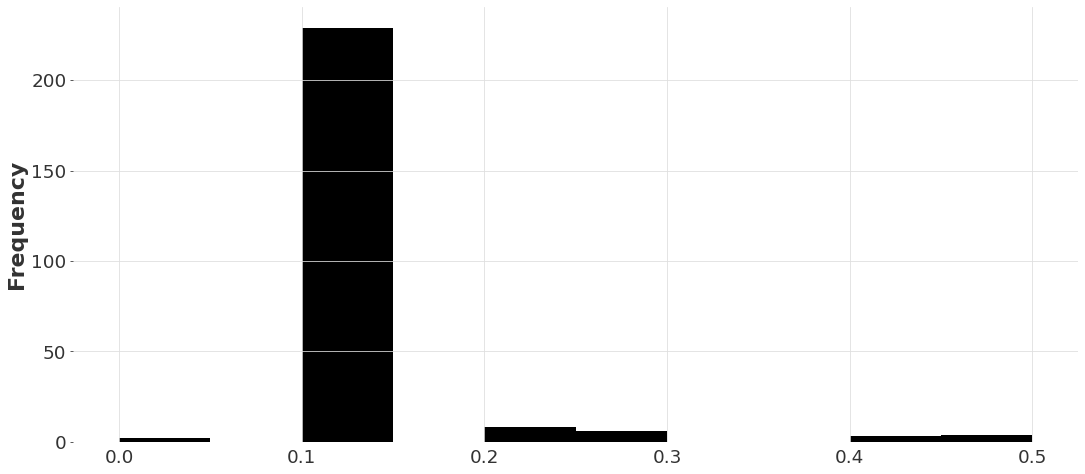

In [102]:
result_weekly['disount'].plot.hist()

In [103]:
alt.Chart(all_items_eval.reset_index()).mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=True),axis=alt.Axis(format='%')),
    color=alt.Color('model:N')
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

In [104]:
eval_df[['rmse','rmse_normalized']] = eval_df[['rmse','rmse_normalized']].astype('float16')#.groupby('model')#.sum()
all_items_eval[['rmse','rmse_normalized']] = eval_df.groupby('model').mean()[['rmse','rmse_normalized']]

In [105]:
all_items_eval

value  sell_price  daily_revenue   disount  \
model                                                                     
Fact                 211958.000000   56.484278  285054.632888  0.119048   
Naive weekly         214032.000000   56.484278  287843.880327  0.114286   
noisy_normal_0u_10p  206639.554902   56.484278  277902.048815  0.121429   
noisy_normal_0u_20p  250171.001183   56.484278  336445.913349  0.121429   
noisy_normal_0u_30p  241461.783151   56.484278  324733.201637  0.114286   
noisy_normal_0u_40p  228687.163995   56.484278  307553.079284  0.111905   

                     sell_price_w_disount  value_increase  value_w_disount  \
model                                                                        
Fact                            49.759959            15.0    288491.900000   
Naive weekly                    50.028932            14.4    286936.500000   
noisy_normal_0u_10p             49.625473            15.3    280976.096733   
noisy_normal_0u_20p             49.625473            15.3    339640.671925   
noisy_normal_0u_30p             50.028932            14.4    323466.149974   
noisy_normal_0u_40p             50.163418            14.1    304812.030296   

                     daily_revenue_w_disount   daily_profit  \
model                                                         
Fact                           336549.425921  171032.779733   
Naive weekly                   339075.564214  172706.328196   
noisy_normal_0u_10p            328254.740790  166741.229289   
noisy_normal_0u_20p            395552.729120  201867.548009   
noisy_normal_0u_30p            382842.363312  194839.920982   
noisy_normal_0u_40p            362502.592770  184531.847570   

                     daily_profit_w_disount  value_fact  daily_profit_fact  \
model                                                                        
Fact                          181356.505351    211958.0      171032.779733   
Naive weekly                  184719.364080    211958.0      171032.779733   
noisy_normal_0u_10p           177104.912796    211958.0      171032.779733   
noisy_normal_0u_20p           212844.556653    211958.0      171032.779733   
noisy_normal_0u_30p           208835.202209    211958.0      171032.779733   
noisy_normal_0u_40p           198530.331480    211958.0      171032.779733   

                     value_w_disount_fact  daily_profit_w_disount_fact  \
model                                                                    
Fact                             288491.9                181356.505351   
Naive weekly                     283934.6                182977.671370   
noisy_normal_0u_10p              288207.8                181663.201531   
noisy_normal_0u_20p              287761.4                180333.077478   
noisy_normal_0u_30p              283942.4                183318.002593   
noisy_normal_0u_40p              282514.1                184007.231822   

                     inventory_left  final_profit_w_discount  \
model                                                          
Fact                       0.000000            181356.505351   
Naive weekly            3001.900000            160715.657396   
noisy_normal_0u_10p    -7231.703267            173214.650537   
noisy_normal_0u_20p    51879.271925            152424.856390   
noisy_normal_0u_30p    39523.749974            162056.378990   
noisy_normal_0u_40p    22297.930296            172012.160469   

                     final_profit_base_price  profit_increase_%       rmse  \
model                                                                        
Fact                           171032.779733           0.060361    0.00000   
Naive weekly                   147156.337507           0.092142  197.50000   
noisy_normal_0u_10p            161307.124084           0.073819   19.25000   
noisy_normal_0u_20p            143124.558646           0.064980  138.25000   
noisy_normal_0u_30p            149771.156130           0.082027  106.75000   
noisy_normal_0u_40p  

In [106]:
chart = alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('rmse:Q'),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

fact_line = alt.Chart(pd.DataFrame({'y': [all_items_eval.loc['Fact','profit_increase_%']]})).mark_rule(strokeDash=[10, 10]).encode(y='y')

chart + fact_line

alt.LayerChart(...)

In [107]:
alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('disount:Q',axis=alt.Axis(format='%')),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

alt.Chart(...)

In [108]:
all_items_eval

value  sell_price  daily_revenue   disount  \
model                                                                     
Fact                 211958.000000   56.484278  285054.632888  0.119048   
Naive weekly         214032.000000   56.484278  287843.880327  0.114286   
noisy_normal_0u_10p  206639.554902   56.484278  277902.048815  0.121429   
noisy_normal_0u_20p  250171.001183   56.484278  336445.913349  0.121429   
noisy_normal_0u_30p  241461.783151   56.484278  324733.201637  0.114286   
noisy_normal_0u_40p  228687.163995   56.484278  307553.079284  0.111905   

                     sell_price_w_disount  value_increase  value_w_disount  \
model                                                                        
Fact                            49.759959            15.0    288491.900000   
Naive weekly                    50.028932            14.4    286936.500000   
noisy_normal_0u_10p             49.625473            15.3    280976.096733   
noisy_normal_0u_20p             49.625473            15.3    339640.671925   
noisy_normal_0u_30p             50.028932            14.4    323466.149974   
noisy_normal_0u_40p             50.163418            14.1    304812.030296   

                     daily_revenue_w_disount   daily_profit  \
model                                                         
Fact                           336549.425921  171032.779733   
Naive weekly                   339075.564214  172706.328196   
noisy_normal_0u_10p            328254.740790  166741.229289   
noisy_normal_0u_20p            395552.729120  201867.548009   
noisy_normal_0u_30p            382842.363312  194839.920982   
noisy_normal_0u_40p            362502.592770  184531.847570   

                     daily_profit_w_disount  value_fact  daily_profit_fact  \
model                                                                        
Fact                          181356.505351    211958.0      171032.779733   
Naive weekly                  184719.364080    211958.0      171032.779733   
noisy_normal_0u_10p           177104.912796    211958.0      171032.779733   
noisy_normal_0u_20p           212844.556653    211958.0      171032.779733   
noisy_normal_0u_30p           208835.202209    211958.0      171032.779733   
noisy_normal_0u_40p           198530.331480    211958.0      171032.779733   

                     value_w_disount_fact  daily_profit_w_disount_fact  \
model                                                                    
Fact                             288491.9                181356.505351   
Naive weekly                     283934.6                182977.671370   
noisy_normal_0u_10p              288207.8                181663.201531   
noisy_normal_0u_20p              287761.4                180333.077478   
noisy_normal_0u_30p              283942.4                183318.002593   
noisy_normal_0u_40p              282514.1                184007.231822   

                     inventory_left  final_profit_w_discount  \
model                                                          
Fact                       0.000000            181356.505351   
Naive weekly            3001.900000            160715.657396   
noisy_normal_0u_10p    -7231.703267            173214.650537   
noisy_normal_0u_20p    51879.271925            152424.856390   
noisy_normal_0u_30p    39523.749974            162056.378990   
noisy_normal_0u_40p    22297.930296            172012.160469   

                     final_profit_base_price  profit_increase_%       rmse  \
model                                                                        
Fact                           171032.779733           0.060361    0.00000   
Naive weekly                   147156.337507           0.092142  197.50000   
noisy_normal_0u_10p            161307.124084           0.073819   19.25000   
noisy_normal_0u_20p            143124.558646           0.064980  138.25000   
noisy_normal_0u_30p            149771.156130           0.082027  106.75000   
noisy_normal_0u_40p  